# Goal
The goal of this program is to train a model to recognize hand-written digits 0-9.

# Strategy
- Download the MNIST data of labeled images of digits. 
- Create data loaders with training and validation data.
- Define a model with linear and ReLU layers.
- Define a loss function suitable for classification task.
- Define a metric function to measure the performance of the model.
- Run training epochs and print metrics after each epoch.
- Export the trained model so that it can be used to create an app with Gradio + HF Spaces.

In [118]:
from fastai.vision.all import *

def load_and_label(p):
    dirs = p.ls().sorted()
    images_by_category = [ [tensor(Image.open(file)) for file in dir.ls().sorted() if file.is_file()] for dir in dirs] 
    labels = torch.cat( [ torch.full( (len(images_by_category[i]),), i) for i in range(len(images_by_category))])  
    # labels = labels.unsqueeze(1).float()
    images = torch.cat([torch.stack(l) for l in images_by_category])
    images = images.view(-1, 28*28).float()
    return (images, labels)
    
def to_dataset(images, labels):
    return list(zip(images, labels))

def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

def init():
    # Create the datasets
    path = untar_data(URLs.MNIST)
    train_path = path/"training"
    valid_path = path/"testing"
    
    (train_xs, train_ys) = load_and_label(train_path) 
    (valid_xs, valid_ys) = load_and_label(valid_path) 
    
    train_dset = to_dataset(train_xs, train_ys)
    valid_dset = to_dataset(valid_xs, valid_ys)
    
    train_dl = DataLoader(train_dset, batch_size=256)
    valid_dl = DataLoader(valid_dset, batch_size=256) 
    
    return (train_xs, train_ys, valid_xs, valid_ys, train_dl, valid_dl)
    
#def mnist_loss(predictions, targets):
#    # Use cross_entropy for classification tasks.
#    # predictions.size() should be [batch_size, num_classes]
#    # targets.size() should be [batch_size]
#    return F.cross_entropy(predictions, targets)

# def calc_grad(xb, yb, model):
#     preds = model(xb)
#     loss = mnist_loss(preds, yb)
#     loss.backward()
# 
# def train_epoch(model, lr, params):
#     for xb, yb in train_dl:
#         calc_grad(xb, yb, model)
#         for p in params:
#             p.data -= p.grad*lr
#             p.grad.zero_()

def batch_accuracy(xb, yb):
    preds = torch.argmax(xb, dim=1)
    correct = (preds == yb)
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [119]:
(train_xs, 
 train_ys, 
 valid_xs, 
 valid_ys, 
 train_dl, 
 valid_dl) = init()

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.151877,2.242069,0.153700,00:01
1,1.850147,2.007809,0.212500,00:01
2,1.543387,1.858581,0.263800,00:01
3,1.234436,1.745063,0.359900,00:01
4,0.991796,1.638225,0.424200,00:01
5,0.827512,1.535304,0.464800,00:01
6,0.713592,1.444758,0.500700,00:01
7,0.635005,1.372294,0.524700,00:01
8,0.580130,1.315258,0.542900,00:01
9,0.539814,1.268838,0.559300,00:01


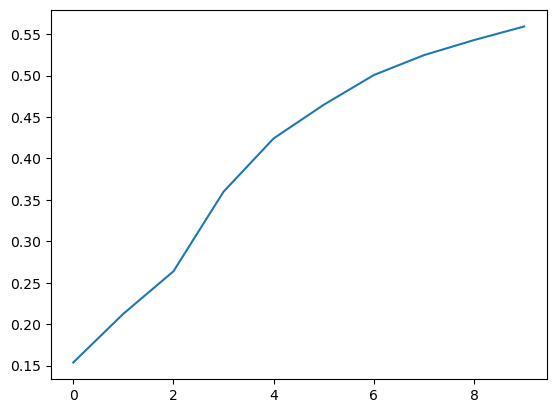

In [126]:
model = nn.Sequential(
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, model, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=batch_accuracy)
learn.model.train()
learn.fit(20, lr=1e-4)
plt.plot(L(learn.recorder.values).itemgot(2))

In [130]:
??learn.lr_find()

Object `learn.lr_find()` not found.


In [142]:
learn.load("digit_classifier_94")

In [147]:
# Save the current model
learn.save("digit_classifier_95")

Path('models/digit_classifier_95.pth')

In [140]:
1e-4 + 1e-4

0.0002

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.162387,0.154575,0.954300,00:01
1,0.164328,0.154266,0.953900,00:01
2,0.165545,0.154101,0.953800,00:01
3,0.166283,0.154000,0.953900,00:01
4,0.166729,0.153931,0.953900,00:01
5,0.167009,0.153876,0.954000,00:01
6,0.167181,0.153829,0.954000,00:01
7,0.167288,0.153786,0.954100,00:01
8,0.167347,0.153747,0.954100,00:01
9,0.167375,0.153710,0.954100,00:01


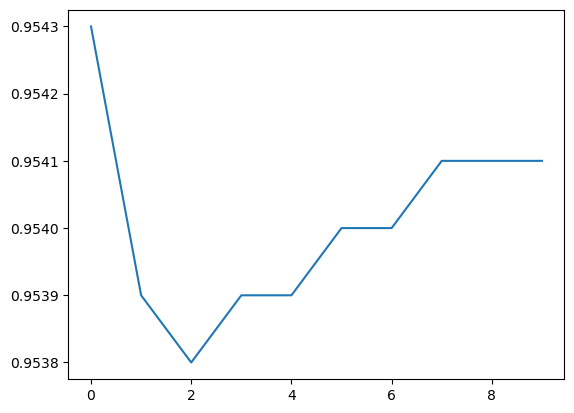

In [146]:
learn.fit(10, lr=0.000005)
plt.plot(L(learn.recorder.values).itemgot(2))

tensor([[ 2.3794, -4.4954, -0.9659, -1.0014, -1.7335,  6.4931, -2.8767, -0.2632,
          4.2000,  7.2766]])
The model predicts the digit is: 9


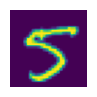

In [128]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open((path/"testing/5/").ls().sorted()[1])
img_tensor = tensor(img).float()
show_image(img_tensor)
img_tensor = img_tensor.view(-1, 28*28)  # Flatten

with torch.no_grad():  # No need to calculate gradients
    learn.model.eval()
    output = learn.model(img_tensor)
    print(output)
    predicted_class = torch.argmax(output, dim=1)

print(f"The model predicts the digit is: {predicted_class.item()}")

In [96]:
print(train_ys[55000])

tensor(9)


# Summary

Eventually, I was able to get pretty good results at classifying all the digits.

After setting up the model, I spent a good amoung of time trying to find a good learning rate for my (arbitrarily chosen) set of model parameters.

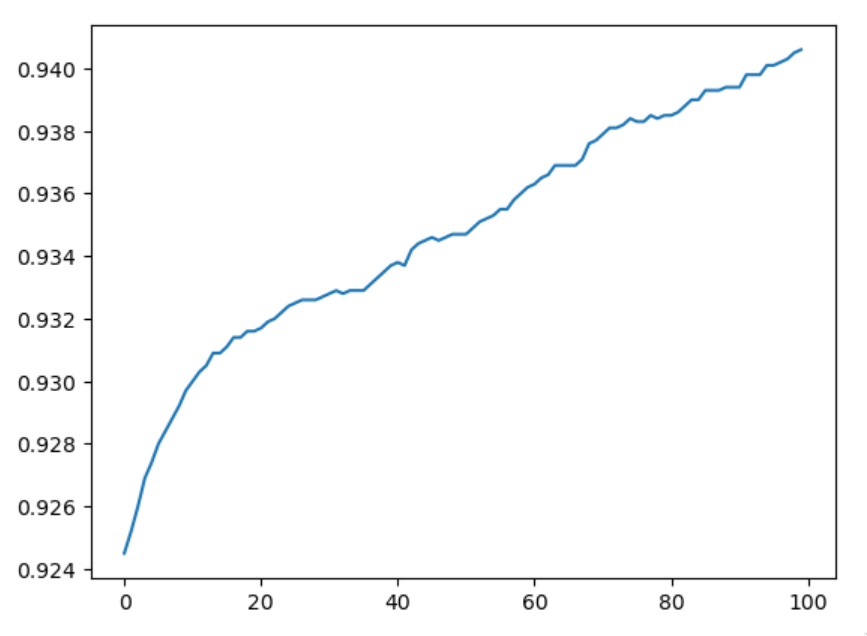

This was an iterative process where I:
- Got the model working at all (fixed bugs in my code)
- Did some epochs of training
- Adjusted parameters (like learning rate) until 5-10 epochs of training led to _any_ improvement
- Set up a "manual" test process where I could check what my model's predicted weights were across all classes
- Save a snapshot of the model with `learn.save`
- Adjust the learning rate and train more
- If the accuracy got worse, reload from the snapshot with `learn.load`
